## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [110]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [111]:
df = pd.read_csv('ab_data.csv')

b. Use the cell below to find the number of rows in the dataset.

In [112]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [113]:
len(df.user_id.unique())

290584

d. The proportion of users converted.

In [114]:
(df.converted==1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [115]:
len(df.query('group == "treatment" & landing_page != "new_page" '))


1965

f. Do any of the rows have missing values?

In [32]:
df.isnull().values.any().sum()

0

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [116]:
# create treatment dataframe from query
df2 = df.query("group=='treatment' & landing_page=='new_page'")

#add control group
df2 = df2.append(df.query("group=='control' & landing_page=='old_page'"))


# show column and row count
df2.shape

(290585, 5)

In [34]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [117]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [36]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [37]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [38]:
# drop duplicate
df2 = df2.drop_duplicates(subset=['user_id'])

# check user
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [39]:
(df2.converted==1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [40]:
(df2.query('group == "control"')['converted']==1).mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [41]:
(df2.query('group == "treatment"')['converted']==1).mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [42]:
(df['landing_page']=='new_page').mean()

0.5

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

***

*There is not enough evidence to suggest that new treatment page leads to more conversions. The control group, which recived the old page, average is too close, if not higher than the treatment group average.*

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

***
$$H_0: p_{new} - p_{old} \leq 0$$

$$H_1: p_{new} - p_{old} > 0$$
***

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [43]:
# set p-new to overal conversion rate
p_new = (df2.converted==1).mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [44]:
# p-old is the same as p-new under the current model
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [45]:
# query treatment group
n_new = df2.query('group == "treatment"').user_id.nunique()
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [46]:
# query control group
n_old = df2.query('group == "control"').user_id.nunique()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [47]:
new_page_converted = np.random.choice([0,1], n_new, p=(1-p_new, p_new))

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [48]:
old_page_converted = np.random.choice([0,1], n_old, p=(1-p_old, p_old))

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [49]:
new_page_converted.mean() - old_page_converted.mean()

0.001918007998434862

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [50]:
# create container for diffs
p_diffs=[]

# create 10,000 simulated diffs and put in container
for _ in range(10000):
    new_b_samp = np.random.choice([0,1], n_new, p=(1-p_new, p_new))
    old_b_samp = np.random.choice([0,1], n_old, p=(1-p_old, p_old))
    new = new_b_samp.mean()
    old = old_b_samp.mean()
    p_diffs.append(new - old)

# convert to array    
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

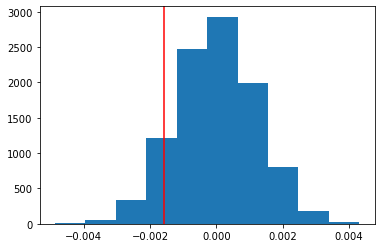

In [52]:
# obverved difference from orignal data
obbs_diff = ((df2.query('group == "treatment"')['converted']==1).mean()) - (df2.query('group == "control"')['converted']==1).mean()

#plot histogram
plt.hist(p_diffs)
plt.axvline(x=obbs_diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [53]:
# calc p-value
p = (p_diffs > obbs_diff).mean()
print(p)

0.9064


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

***
*This value, computed for the variable **p**, is called the p value. The P-value is difined as "if $H_0$ is true, the probability of obtaining the observed statistic or one more extreme in favor of the alternative hypothesis'.*

*The larger the P-value the more likely the null is true. In this case the P-value is very close to 1.0, therefore, the probability of the alternative being true is very low. I failed to reject the null.*

***

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [54]:
import statsmodels.api as sm

#find control conversion rate
convert_old = (df2.query('group == "control"')['converted']==1).sum()

#find treatment conversion rate
convert_new = (df2.query('group == "treatment"')['converted']==1).sum()

# find control group count
n_old = df2.query('group == "control"').user_id.nunique()

# find treatment group count
n_new = df2.query('group == "treatment"').user_id.nunique()

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [55]:
# create array of group counts
count = np.array([convert_new, convert_old])

# calc num of observations
nobs = np.array([n_new, n_old])

# calc stats
stat, pval = sm.stats.proportions_ztest(count, nobs, value=0, alternative='larger' )

# dispaly stats
print('Z-score:', stat)
print('P-value:', pval)

Z-score: -1.3109241984234394
P-value: 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

***

*The z-score shows that the means of the two test groups are not equal. The negative correlation indictates that the control group mean in higher than the treatment group.*

*The p-value show me that I have failed to reject the null. I am no where near the T1 error threshhold to justify rejecting the null.*

*The p-value here and the simulated p-value are extremly close further strengthing the conlusion that I fail to reject the null.*

***

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

***
*Since the responce is binary (either/or) and because I am trying to predict the response of catigorical data, I should use a Logistic Regression model.*
***

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [118]:
# create dummies
df2[['ab_page', 'old_page']] = pd.get_dummies(df2['landing_page'])

# create intercept column
df2['intercept'] = 1

# display
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [119]:
# calc and display regresion stats
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Feb 2022   Pseudo R-squ.:               8.085e-06
Time:                        01:42:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

***
*In a regression model, the null hypothsis is   $$H_0: p_{new} - p_{old} = 0$$*
*$$H_1: p_{new} - p_{old} \neq 0$$*
                                        
*So, with the regression model p-value it is closer to zero $H_1$, which the assumption that $p_{new} - p_{old} \neq 0$.
But, because the p-value is not under the $\alpha$ thershold, I have to go with $H_0$.*
***

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

***
*Adding other factors into the reggresion model can help show trends about certain user groups. Rual areas my seem to like the more simplistic page, while the uraban group prefered the flashy, JavaScript enhanced features. The web page may be more a success in foreign countries verses domestic land.*

*Adding addional terms will certainly change the p-values and other numbers. One can never be sure if they will lead to confusing answers. Should we launch the new page anyway because i do not care about forign markets and there is growth promise domesticaly?*

*Adding unneaded or insignificant factors should be avoided to not muddy the dicision waters.*

***

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [122]:
# load countries
df_c = pd.read_csv('countries.csv')
print(df_c.shape)
print(df_c['country'].unique())
df_c.head()

(290584, 2)
['UK' 'US' 'CA']


,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [121]:
#merge tables
df_new = df2.merge(df_c, on = 'user_id', how = 'inner', suffixes = ("", '_c'))
print(df_new.shape)
df_new.head()

(290585, 9)


,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA


In [126]:
# create and display dummies
df_new[['CA', 'UK','US']] = pd.get_dummies(df_new['country'])
df_new.head()

,user_id,timestamp,group,landing_page,converted,ab_page,old_page,intercept,country,CA,UK,US
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,US,0,0,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,US,0,0,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,0,1,CA,1,0,0
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,0,1,UK,0,1,0
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,0,1,CA,1,0,0


In [137]:
# calc and display regresion stats
logit_mod2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page','UK', 'US']])
results2 = logit_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Tue, 08 Feb 2022   Pseudo R-squ.:               2.324e-05
Time:                        14:40:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0150      0.011     -1.308      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

***
*There seems to be a positive relationship with the UK, and US and the conversion rate. Calculating the coef, Canada follows the negative relationship narative, though. This shows a different light on how the web pages are affecting different groups.*

***

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [138]:

# create interactions
df_new['us_inter'] = df_new['US'] * df_new['ab_page']
df_new['uk_inter'] = df_new['UK'] * df_new['ab_page']

# calc and display regresion stats
logit_mod3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'uk_inter','UK', 'us_inter', 'US']])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Tue, 08 Feb 2022   Pseudo R-squ.:               3.483e-05
Time:                        14:57:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1918
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
uk_inter       0.0783      0.057      1.378      0.168      -0.033       0.190
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
us_inter       0.0469      0.054      0.872      0.383      -0.059       0.152
US             0.0175      0.038      0.465      0.642      -0.056       0.091
==============================================================================
"""

***
*It is not easy to interpret the coefficients for interations, or other Higher Order Terms. The interactions  seem to have taken on the coefficients of there base varibles. I am not entirely sure what that means in terms of my A|B test. The UK and US variables still show a slight, positive correlation though.*
***

***
# Conclusion

*Overall the new web page is not a success. In the A|B test I failed to reject the null. The overall averages showed the old page was reciving a better conversion rate. In the regression model, There was a definate trend with countries.*

*I would not reccomend switching the web pages. I fail to reject $H_0$ in all the test.
Because the US and UK show some positive correlation in the regression model, though, the company could consider testing geo-located web content.*
***

In [136]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])